# Neural Machine Translation using RNNs, Transformer Model (February 21st, 2025)

## Dataset

In [ ]:
! pip install -q datasets
! pip install -q transformers
! pip install -q tokenizers

In [ ]:
from datasets import load_dataset

ds = load_dataset("thainq107/iwslt2015-en-vi")

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['en', 'vi'],
        num_rows: 133317
    })
    validation: Dataset({
        features: ['en', 'vi'],
        num_rows: 1268
    })
    test: Dataset({
        features: ['en', 'vi'],
        num_rows: 1268
    })
})

In [ ]:
ds['train'][0]

{'en': 'Rachel Pike : The science behind a climate headline',
 'vi': 'Khoa học đằng sau một tiêu đề về khí hậu'}

In [ ]:
ds["train"]["en"]

['Rachel Pike : The science behind a climate headline',
 'In 4 minutes , atmospheric chemist Rachel Pike provides a glimpse of the massive scientific effort behind the bold headlines on climate change , with her team -- one of thousands who contributed -- taking a risky flight over the rainforest in pursuit of data on a key molecule .',
 'I &apos;d like to talk to you today about the scale of the scientific effort that goes into making the headlines you see in the paper .',
 'Headlines that look like this when they have to do with climate change , and headlines that look like this when they have to do with air quality or smog .',
 'They are both two branches of the same field of atmospheric science .',
 'Recently the headlines looked like this when the Intergovernmental Panel on Climate Change , or IPCC , put out their report on the state of understanding of the atmospheric system .',
 'That report was written by 620 scientists from 40 countries .',
 'They wrote almost a thousand pages

## Tokenizer

In [ ]:
from tokenizers import Tokenizer, pre_tokenizers, trainers, models

# Create word-level tokenizer
tokenizer_en = Tokenizer(models.WordLevel(unk_token="<unk>"))
tokenizer_vi = Tokenizer(models.WordLevel(unk_token="<unk>"))

tokenizer_en.pre_tokenizer = pre_tokenizers.Whitespace()
tokenizer_vi.pre_tokenizer = pre_tokenizers.Whitespace()

trainer = trainers.WordLevelTrainer(
    vocab_size=15000,
    min_frequency=2,
    special_tokens=["<pad>", "<unk>", "<bos>", "<eos>"]
)

In [ ]:
tokenizer_en.get_vocab()

{}

In [ ]:
# Train tokenizers
tokenizer_en.train_from_iterator(ds["train"]["en"], trainer)
tokenizer_vi.train_from_iterator(ds["train"]["vi"], trainer)

In [ ]:
tokenizer_en.get_vocab()

{'receiver': 8250,
 'understanding': 752,
 'These': 319,
 'professor': 2102,
 'kicks': 11423,
 'Dai': 12662,
 'thyroid': 9653,
 'malarial': 13352,
 'nailed': 13392,
 'Nelson': 4338,
 'lived': 903,
 'pyramid': 4566,
 'agreements': 11149,
 'gratification': 8542,
 'unveils': 10913,
 'avant': 14198,
 'invasion': 8562,
 'holding': 1745,
 'Riverside': 9288,
 'Michael': 2147,
 'Master': 13966,
 'forced': 2177,
 'nonviolence': 8222,
 'diplomats': 11286,
 'law': 876,
 '900': 6221,
 'JH': 5051,
 'orthopedic': 9563,
 'fluids': 11335,
 'propose': 4900,
 'Hands': 11787,
 'sponsored': 9134,
 'UN': 11903,
 'workshops': 9188,
 'total': 1646,
 'vibration': 10245,
 'embark': 13184,
 'confuse': 8908,
 'beloved': 5077,
 'megawatts': 14688,
 'swam': 7099,
 'Enceladus': 10311,
 'motorbikes': 14713,
 'McGonigal': 11044,
 'liver': 2788,
 'hospital': 1084,
 'fee': 7820,
 'Western': 1226,
 'conscience': 5750,
 'succession': 14996,
 'Better': 8353,
 '@': 9693,
 'travel': 1199,
 'virtually': 3484,
 'vegetation': 

In [ ]:
# Store tokenizers
tokenizer_en.save("tokenizer_en.json")
tokenizer_vi.save("tokenizer_vi.json")

In [ ]:
len(tokenizer_en.get_vocab()), len(tokenizer_vi.get_vocab())

(15000, 13684)

In [ ]:
tokenizer_en.encode("how are you")

Encoding(num_tokens=3, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [ ]:
tokenizer_en.encode("how are you").ids

[81, 27, 18]

In [ ]:
tokenizer_en.encode("how are you").tokens

['how', 'are', 'you']

In [ ]:
tokenizer_vi.encode("bạn có khoẻ không").ids

[18, 9, 596, 14]

## Encoding

In [ ]:
from transformers import PreTrainedTokenizerFast

# Load trained tokenizers into PreTrainedTokenizerFast
tokenizer_en = PreTrainedTokenizerFast(
    tokenizer_file="tokenizer_en.json",
    unk_token="<unk>", pad_token="<pad>", bos_token="<bos>", eos_token="<eos>"
)
tokenizer_vi = PreTrainedTokenizerFast(
    tokenizer_file="tokenizer_vi.json",
    unk_token="<unk>", pad_token="<pad>", bos_token="<bos>", eos_token="<eos>"
)

In [ ]:
len(tokenizer_en), len(tokenizer_vi)

(15000, 13684)

In [ ]:
MAX_LEN = 75

def preprocess_function(examples):
    src_texts = examples["en"]
    tgt_texts = ["<bos> " + sent + "<eos>" for sent in examples["vi"]]

    src_encodings = tokenizer_en(
        src_texts, padding="max_length", truncation=True, max_length=MAX_LEN
    )
    tgt_encodings = tokenizer_vi(
        tgt_texts, padding="max_length", truncation=True, max_length=MAX_LEN
    )

    return {
        "input_ids": src_encodings["input_ids"],
        "labels": tgt_encodings["input_ids"],
    }

preprocessed_ds = ds.map(preprocess_function, batched=True)

In [ ]:
preprocessed_ds['train']

Dataset({
    features: ['en', 'vi', 'input_ids', 'labels'],
    num_rows: 133317
})

In [ ]:
print(preprocessed_ds['train'][0])

{'en': 'Rachel Pike : The science behind a climate headline', 'vi': 'Khoa học đằng sau một tiêu đề về khí hậu', 'input_ids': [6675, 1, 57, 60, 339, 604, 13, 744, 5643, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': [2, 1960, 66, 1157, 131, 8, 376, 113, 38, 417, 735, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


In [ ]:
f'{tokenizer_vi.pad_token_id=}, {tokenizer_vi.unk_token_id=},{tokenizer_vi.bos_token_id=}, {tokenizer_vi.eos_token_id=}'

'tokenizer_vi.pad_token_id=0, tokenizer_vi.unk_token_id=1,tokenizer_vi.bos_token_id=2, tokenizer_vi.eos_token_id=3'

## Model

### GRU

In [ ]:
import torch
import torch.nn as nn
from transformers import PreTrainedModel, PretrainedConfig

class Seq2SeqRNNConfig(PretrainedConfig):
    def __init__(self,
                 vocab_size_src=10000, vocab_size_tgt=10000,
                 embedding_dim=128, hidden_size=128, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.vocab_size_src = vocab_size_src
        self.vocab_size_tgt = vocab_size_tgt
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.dropout = dropout

class EncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))  # B x S x E
        output, hidden = self.gru(embedded)  # B x S x H, 1 x B x H
        return output, hidden

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding_dim, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)  # LM Head

    def forward(self, input, hidden):
        output = self.embedding(input) # B x S x E
        output, hidden = self.gru(output, hidden) # B x S x H, 1 x B x H
        output = self.out(output)  # B x 1 x Vocab
        return output, hidden

class Seq2SeqRNNModel(PreTrainedModel):
    config_class = Seq2SeqRNNConfig

    def __init__(self, config, tokenizer_en):
        super().__init__(config)
        self.encoder = EncoderRNN(
            config.vocab_size_src, config.embedding_dim,
            config.hidden_size, config.dropout)
        self.decoder = DecoderRNN(
            config.hidden_size, config.embedding_dim, config.vocab_size_tgt)
        self.BOS_IDX = tokenizer_en.bos_token_id
        self.loss_fn = nn.CrossEntropyLoss(ignore_index=0)  # Ignore PAD Token

    def forward(self, input_ids, labels):
        batch_size, seq_len = labels.shape
        decoder_input = torch.full((batch_size, 1), self.BOS_IDX, dtype=torch.long).to(input_ids.device)
        _, decoder_hidden = self.encoder(input_ids) # 1 x B x H
        decoder_outputs = []

        for i in range(seq_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)
            decoder_input = labels[:, i].unsqueeze(1)  # Teacher forcing

        logits = torch.cat(decoder_outputs, dim=1)  # B x S x Vocab
        loss = self.loss_fn(logits.view(-1, logits.shape[-1]), labels.view(-1))
        return {"loss": loss, "logits": logits}

In [ ]:
config = Seq2SeqRNNConfig(
    vocab_size_src=len(tokenizer_en), vocab_size_tgt=len(tokenizer_vi)
)
model_gru = Seq2SeqRNNModel(config, tokenizer_en)

In [ ]:
model_gru

Seq2SeqRNNModel(
  (encoder): EncoderRNN(
    (embedding): Embedding(15000, 128)
    (gru): GRU(128, 128, batch_first=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): DecoderRNN(
    (embedding): Embedding(13684, 128)
    (gru): GRU(128, 128, batch_first=True)
    (out): Linear(in_features=128, out_features=13684, bias=True)
  )
  (loss_fn): CrossEntropyLoss()
)

### Transformer

In [ ]:
import torch
import torch.nn as nn
from transformers import PreTrainedModel, PretrainedConfig

def generate_square_subsequent_mask(sz, device):
    mask = torch.full((sz, sz), float("-inf"), device=device)
    mask = torch.triu(mask, diagonal=1)
    return mask

def create_mask(src, tgt):
    src_seq_len = src.shape[1]
    tgt_seq_len = tgt.shape[1]
    device = src.device

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len, device).to(torch.bool)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=device).type(torch.bool)
    src_padding_mask = (src == 0)
    tgt_padding_mask = (tgt == 0)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

class Seq2SeqTransformerConfig(PretrainedConfig):
    def __init__(
            self, vocab_size_src=10000, vocab_size_tgt=10000, max_seq_length=50,
            d_model=256, num_heads=8, num_layers=6, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.vocab_size_src = vocab_size_src
        self.vocab_size_tgt = vocab_size_tgt
        self.max_seq_length = max_seq_length
        self.d_model = d_model
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.dropout = dropout

class Seq2SeqTransformerModel(PreTrainedModel):
    config_class = Seq2SeqTransformerConfig

    def __init__(self, config):
        super().__init__(config)

        self.embedding_src = nn.Embedding(
            config.vocab_size_src, config.d_model)
        self.embedding_tgt = nn.Embedding(
            config.vocab_size_tgt, config.d_model)

        self.position_embedding_src = nn.Embedding(
            config.max_seq_length, config.d_model)
        self.position_embedding_tgt = nn.Embedding(
            config.max_seq_length, config.d_model)

        self.transformer = nn.Transformer(
            d_model=config.d_model,
            nhead=config.num_heads,
            num_encoder_layers=config.num_layers,
            num_decoder_layers=config.num_layers,
            dropout=config.dropout,
            batch_first=True
        )

        self.generator = nn.Linear(
            config.d_model, config.vocab_size_tgt
            )
        self.loss_fn = nn.CrossEntropyLoss(ignore_index=0)  # Ignore PAD token

    def forward(self, input_ids, labels):
        tgt_input = labels[:, :-1]
        tgt_output = labels[:, 1:] # N x (T-1)
        _, seq_len_src = input_ids.shape
        _, seq_len_tgt = tgt_input.shape

        src_positions = torch.arange(seq_len_src, device=input_ids.device).unsqueeze(0)
        tgt_positions = torch.arange(seq_len_tgt, device=labels.device).unsqueeze(0)

        src_embedded = self.embedding_src(input_ids) + self.position_embedding_src(src_positions)
        tgt_embedded = self.embedding_tgt(tgt_input) + self.position_embedding_tgt(tgt_positions)

        src_mask, tgt_mask, src_key_padding_mask, tgt_key_padding_mask = create_mask(input_ids, tgt_input)

        outs = self.transformer(
            src_embedded, tgt_embedded, # N x S x E, N x T x E
            src_mask, tgt_mask, # S x S, T x T
            src_key_padding_mask=src_key_padding_mask, # N x S
            tgt_key_padding_mask=tgt_key_padding_mask # N x T
        ) # N x T x E

        logits = self.generator(outs) # N x T x Vocab
        loss = self.loss_fn(logits.permute(0, 2, 1), tgt_output)

        return {"loss": loss, "logits": logits}

    def encode(self, src, src_mask):
        _, seq_len_src = src.shape
        src_positions = torch.arange(seq_len_src, device=src.device).unsqueeze(0)
        src_embedded = self.embedding_src(src) + self.position_embedding_src(
            src_positions)
        return self.transformer.encoder(src_embedded, src_mask)

    def decode(self, tgt, encoder_output, tgt_mask):
        _, seq_len_tgt = tgt.shape
        tgt_positions = torch.arange(seq_len_tgt, device=tgt.device).unsqueeze(0)
        tgt_embedded = self.embedding_tgt(tgt) + self.position_embedding_tgt(
            tgt_positions)
        return self.transformer.decoder(
            tgt_embedded, encoder_output, tgt_mask
        )

In [ ]:
# Define model config
config = Seq2SeqTransformerConfig(
    vocab_size_src=len(tokenizer_en), vocab_size_tgt=len(tokenizer_vi), max_seq_length=75
)

# Define model
model_transformer = Seq2SeqTransformerModel(config)

In [ ]:
model_transformer

Seq2SeqTransformerModel(
  (embedding_src): Embedding(15000, 256)
  (embedding_tgt): Embedding(13684, 256)
  (position_embedding_src): Embedding(75, 256)
  (position_embedding_tgt): Embedding(75, 256)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((256,), eps=

### Test Model

In [ ]:
input_ids = torch.tensor([preprocessed_ds['train'][0]['input_ids']])
labels = torch.tensor([preprocessed_ds['train'][0]['labels']])

In [ ]:
input_ids

tensor([[6675,    1,   57,   60,  339,  604,   13,  744, 5643,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0]])

In [ ]:
labels

tensor([[   2, 1960,   66, 1157,  131,    8,  376,  113,   38,  417,  735,    3,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0]])

In [ ]:
# model = model_gru
model = model_transformer
pred = model(input_ids, labels)

In [ ]:
pred

{'loss': tensor(9.5264, grad_fn=<NllLoss2DBackward0>),
 'logits': tensor([[[-0.1131,  0.2575, -0.6967,  ...,  0.6266, -0.7508, -0.7830],
          [-0.0751, -0.4865, -0.4983,  ..., -0.2045, -0.6571, -0.7704],
          [ 0.5530,  0.4741, -0.5052,  ...,  0.2489, -0.4464, -0.7355],
          ...,
          [ 0.0909,  0.0409, -0.6442,  ...,  0.1606, -0.1618, -0.6602],
          [ 0.3798,  0.6915, -0.2505,  ...,  0.3305, -0.6380, -1.1403],
          [-0.2710,  0.1101, -0.1898,  ...,  0.0927, -0.3347, -0.9670]]],
        grad_fn=<ViewBackward0>)}

## Trainer

In [ ]:
# Disable wandb
import os
os.environ['WANDB_DISABLED'] = 'true'

# # Use wandb
# import wandb
# wandb.init(
#     project="en-vi-machine-translation",
#     name="transformer" # "gru"
# )

In [ ]:
! pip install accelerate>=0.26.0

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./en-vi-machine-translation",
    logging_dir="logs",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=512,
    per_device_eval_batch_size=512,
    num_train_epochs=25,
    learning_rate=2e-5,
    save_total_limit=1,
    report_to="none",
    # report_to="wandb",
)

trainer = Trainer(
    model=model_transformer,
    args=training_args,
    train_dataset=preprocessed_ds["train"],
    eval_dataset=preprocessed_ds["validation"]
)

In [ ]:
preprocessed_ds["train"]

Dataset({
    features: ['en', 'vi', 'input_ids', 'labels'],
    num_rows: 133317
})

### GRU

In [ ]:
# trainer.train()

### Transformer

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,7.848800,6.849854
2,6.434600,6.047494
3,5.925900,5.730125
4,5.672100,5.522442
5,5.485800,5.357742
6,5.335300,5.227354
7,5.211300,5.116873
8,5.108000,5.025901
9,5.021300,4.946032
10,4.948100,4.882711


TrainOutput(global_step=6525, training_loss=5.080333284692289, metrics={'train_runtime': 45777.3331, 'train_samples_per_second': 72.807, 'train_steps_per_second': 0.143, 'total_flos': 3.13750282752738e+16, 'train_loss': 5.080333284692289, 'epoch': 25.0})

In [ ]:
trainer.state.log_history[-5:]

[{'loss': 4.5638,
  'grad_norm': 0.8987320065498352,
  'learning_rate': 8.000000000000001e-07,
  'epoch': 24.0,
  'step': 6264},
 {'eval_loss': 4.553835868835449,
  'eval_runtime': 5.4441,
  'eval_samples_per_second': 232.915,
  'eval_steps_per_second': 0.551,
  'epoch': 24.0,
  'step': 6264},
 {'loss': 4.5608,
  'grad_norm': 0.9327958226203918,
  'learning_rate': 0.0,
  'epoch': 25.0,
  'step': 6525},
 {'eval_loss': 4.5526533126831055,
  'eval_runtime': 6.6755,
  'eval_samples_per_second': 189.949,
  'eval_steps_per_second': 0.449,
  'epoch': 25.0,
  'step': 6525},
 {'train_runtime': 45777.3331,
  'train_samples_per_second': 72.807,
  'train_steps_per_second': 0.143,
  'total_flos': 3.13750282752738e+16,
  'train_loss': 5.080333284692289,
  'epoch': 25.0,
  'step': 6525}]

In [ ]:
import pandas as pd
df = pd.DataFrame(trainer.state.log_history)
df.head()

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,7.8488,0.994605,0.000019,1.0,261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,1.0,261,6.849854,6.7156,188.816,0.447,NaN,NaN,NaN,NaN,NaN
2,6.4346,0.801272,0.000018,2.0,522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,2.0,522,6.047494,5.3559,236.747,0.560,NaN,NaN,NaN,NaN,NaN
4,5.9259,0.650571,0.000018,3.0,783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
for i in range(0, len(df) - 1, 2):
    df.iloc[i, 5:10] = df.iloc[i + 1, 5:10].values

df = df.drop(df.index[1::2]).reset_index(drop=True)
df

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,7.8488,0.994605,0.000019,1.0,261,6.047494,5.3559,236.747,0.560,NaN,NaN,NaN,NaN,NaN
1,5.9259,0.650571,0.000018,3.0,783,5.522442,4.9463,256.353,0.607,NaN,NaN,NaN,NaN,NaN
2,5.4858,0.636232,0.000016,5.0,1305,5.227354,4.9653,255.371,0.604,NaN,NaN,NaN,NaN,NaN
3,5.2113,0.890093,0.000014,7.0,1827,5.025901,4.9459,256.372,0.607,NaN,NaN,NaN,NaN,NaN
4,5.0213,1.190637,0.000013,9.0,2349,4.882711,4.9747,254.890,0.603,NaN,NaN,NaN,NaN,NaN
5,4.8859,1.607169,0.000011,11.0,2871,4.784392,4.9537,255.969,0.606,NaN,NaN,NaN,NaN,NaN
6,4.7869,0.993353,0.000010,13.0,3393,4.709486,4.9568,255.809,0.605,NaN,NaN,NaN,NaN,NaN
7,4.7128,0.954419,0.000008,15.0,3915,4.654211,4.9364,256.869,0.608,NaN,NaN,NaN,NaN,NaN
8,4.6571,1.143836,0.000006,17.0,4437,4.611452,5.6182,225.696,0.534,NaN,NaN,NaN,NaN,NaN
9,4.6161,0.876245,0.000005,19.0,4959,4.582541,6.7449,187.994,0.445,NaN,NaN,NaN,NaN,NaN


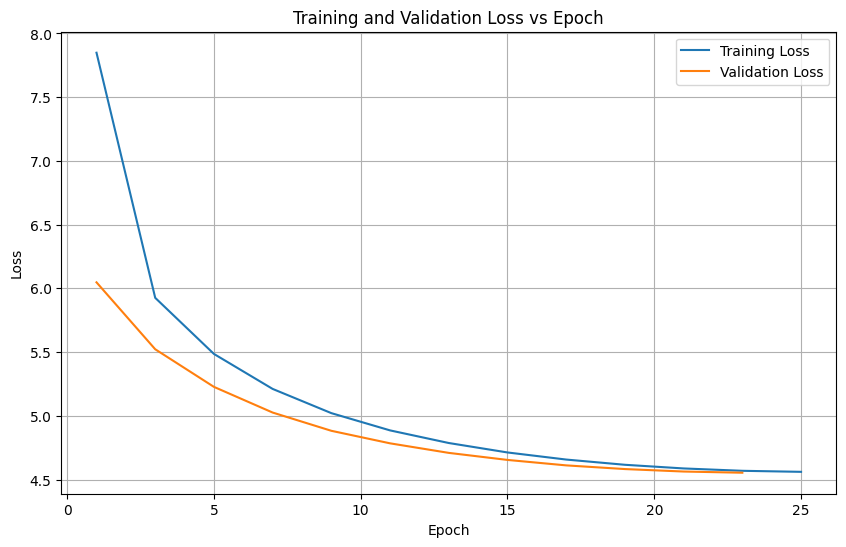

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['loss'], label='Training Loss')
plt.plot(df['epoch'], df['eval_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

## **Inference**

In [ ]:
len(preprocessed_ds["train"]["input_ids"][0])

75

In [ ]:
def greedy_decode(model, src, src_mask, max_len, start_symbol, device="cpu"):
    src = src.to(device)
    src_mask = src_mask.to(device)

    encoder_output = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    for i in range(max_len-1):
        tgt_mask = (generate_square_subsequent_mask(ys.size(1), device))
        out = model.decode(ys, encoder_output, tgt_mask)
        prob = model.generator(out[:, -1, :]) # N x Vocab
        _, next_word = torch.max(prob, dim=1) # N,
        next_word = next_word.unsqueeze(0) # N x 1

        ys = torch.cat([ys, next_word], dim=1)
        if next_word == tokenizer_vi.eos_token_id:
            break
    return ys

def translate(model, src_sentence, device):
    model.eval()
    input_ids = tokenizer_en([src_sentence], return_tensors='pt')['input_ids'].to(device)
    num_tokens = input_ids.shape[1]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool).to(device)
    tgt_tokens = greedy_decode(model,  input_ids, src_mask, max_len=num_tokens + 5, start_symbol=tokenizer_vi.bos_token_id, device=device)
    return tokenizer_vi.decode(tgt_tokens.detach().cpu()[0])

In [ ]:
for i in range (5):
    print(f"EN: {preprocessed_ds['train'][i]['en']}")
    print(f"VI: {preprocessed_ds['train'][i]['vi']}")
    print(f"Predicted: {translate(model_transformer, preprocessed_ds['train'][i]['en'], model_transformer.device)}")
    print()

EN: Rachel Pike : The science behind a climate headline
VI: Khoa học đằng sau một tiêu đề về khí hậu
Predicted: <bos> Đây là một người : Bạn có thể có thể làm một cách

EN: In 4 minutes , atmospheric chemist Rachel Pike provides a glimpse of the massive scientific effort behind the bold headlines on climate change , with her team -- one of thousands who contributed -- taking a risky flight over the rainforest in pursuit of data on a key molecule .
VI: Trong 4 phút , chuyên gia hoá học khí quyển Rachel Pike giới thiệu sơ lược về những nỗ lực khoa học miệt mài đằng sau những tiêu đề táo bạo về biến đổi khí hậu , cùng với đoàn nghiên cứu của mình -- hàng ngàn người đã cống hiến cho dự án này -- một chuyến bay mạo hiểm qua rừng già để tìm kiếm thông tin về một phân tử then chốt .
Predicted: <bos> Một trong một số người khác nhau , một số người đã được sử dụng một số lượng của một số lượng của một người trong một số lượng của một số lượng của một số lượng lớn nhất trong một người trong một 

## Evaluate

In [ ]:
! pip install -q sacrebleu==2.5.1

In [ ]:
from tqdm import tqdm
import sacrebleu

pred_sentences, tgt_sentences = [], []
for sample in tqdm(ds['test']):
    src_sentence = sample['en']
    tgt_sentence = sample['vi']

    pred_sentence = translate(model_transformer, src_sentence, model_transformer.device)
    pred_sentences.append(pred_sentence)

    tgt_sentences.append(tgt_sentence)

bleu_score = sacrebleu.corpus_bleu(pred_sentences, [tgt_sentences], force=True)
bleu_score

In [ ]:
import sacrebleu

pred_sentences = ['tôi đang đi học']
tgt_sentences = ['tôi đang đi tới trường']
bleu_score = sacrebleu.corpus_bleu(
    pred_sentences, [tgt_sentences], force=True
)
bleu_score

BLEU = 46.31 75.0/66.7/50.0/50.0 (BP = 0.779 ratio = 0.800 hyp_len = 4 ref_len = 5)